<img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250"/>

## HW: Deep Learning ##

HW submission by group (up to 4 people)
* John Doe <johndoe@illinois.edu>
* Jane Roes <janeroe@illinois.edu>

Categorical Complexity: Using the data from the lecture, try to use Logistic Regression (you can use sklearn) to predict Townhouse vs Not-Townhouse. What happens? Discuss the loss, compared to what we did in lecture.

In [1]:
### imports and graphics configurations ###
import os
import numpy as np
import pandas as pd
import time
import random
import matplotlib
#%matplotlib notebook
import matplotlib.pyplot as plt
import scipy.stats
#from pandas.plotting import autocorrelation_plot
import matplotlib.offsetbox as offsetbox
from matplotlib.ticker import StrMethodFormatter
import sklearn.linear_model
import torch

def textbox(txt,fname=None):
    plt.figure(figsize=(1,1))
    plt.gca().add_artist(offsetbox.AnchoredText("\n".join(txt), loc="center",prop=dict(size=30)))
    plt.axis('off')
    if fname is not None:
        saver(fname)
    plt.show()
    plt.close()

In [2]:
def getfile(location_pair,**kwargs): #tries to get local version and then defaults to google drive version
    (loc,gdrive)=location_pair
    try:
        out=pd.read_csv(loc,**kwargs)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
        out=pd.read_csv(loc,**kwargs)
    return out

In [3]:
url="https://www.redfin.com"
fname=("redfin_data.csv","https://drive.google.com/file/d/1BFgKwV58YkPX_PRWMuKRHQoT6T0de_Qf/view?usp=sharing")
plot_title="Home Asking Price (Redfin)"
data_color="red"
markersize=2
thinlinesize=2
SEED=0

In [4]:
data_raw=getfile(fname)
data_raw.head()

local file not found; accessing Google Drive


,SALE TYPE,SOLD DATE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,...,STATUS,NEXT OPEN HOUSE START TIME,NEXT OPEN HOUSE END TIME,URL (SEE https://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING),SOURCE,MLS#,FAVORITE,INTERESTED,LATITUDE,LONGITUDE
0,MLS Listing,NaN,Single Family Residential,333 Dodge Ave,Evanston,IL,60202,339900,3.0,2.0,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/333-Dodge-A...,MRED,11818689,N,Y,42.024226,-87.699124
1,MLS Listing,NaN,Condo/Co-op,2254 Sherman Ave #2,Evanston,IL,60201,199000,2.0,1.0,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/2254-Sherma...,MRED,11831019,N,Y,42.059131,-87.682292
2,MLS Listing,NaN,Single Family Residential,2701 Noyes St,Evanston,IL,60201,1075000,5.0,3.5,...,Active,August-5-2023 11:00 AM,August-5-2023 01:00 PM,https://www.redfin.com/IL/Evanston/2701-Noyes-...,MRED,11850222,N,Y,42.058239,-87.710956
3,MLS Listing,NaN,Townhouse,1507 Wilder St,Evanston,IL,60202,825000,4.0,2.5,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/1507-Wilder...,MRED,11849960,N,Y,42.040571,-87.693225
4,MLS Listing,NaN,Single Family Residential,9409 Crawford Ave,Evanston,IL,60203,525000,3.0,1.5,...,Active,August-6-2023 02:00 PM,August-6-2023 04:00 PM,https://www.redfin.com/IL/Evanston/9409-Crawfo...,MRED,11849554,N,Y,42.052003,-87.727151


In [5]:
data=data_raw.copy() #create data on the platform
data.index+=1
data.index.name="record number"

In [6]:
data

,SALE TYPE,SOLD DATE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,...,STATUS,NEXT OPEN HOUSE START TIME,NEXT OPEN HOUSE END TIME,URL (SEE https://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING),SOURCE,MLS#,FAVORITE,INTERESTED,LATITUDE,LONGITUDE
record number,,,,,,,,,,,,,,,,,,,,,
1,MLS Listing,NaN,Single Family Residential,333 Dodge Ave,Evanston,IL,60202,339900,3.0,2.0,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/333-Dodge-A...,MRED,11818689,N,Y,42.024226,-87.699124
2,MLS Listing,NaN,Condo/Co-op,2254 Sherman Ave #2,Evanston,IL,60201,199000,2.0,1.0,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/2254-Sherma...,MRED,11831019,N,Y,42.059131,-87.682292
3,MLS Listing,NaN,Single Family Residential,2701 Noyes St,Evanston,IL,60201,1075000,5.0,3.5,...,Active,August-5-2023 11:00 AM,August-5-2023 01:00 PM,https://www.redfin.com/IL/Evanston/2701-Noyes-...,MRED,11850222,N,Y,42.058239,-87.710956
4,MLS Listing,NaN,Townhouse,1507 Wilder St,Evanston,IL,60202,825000,4.0,2.5,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/1507-Wilder...,MRED,11849960,N,Y,42.040571,-87.693225
5,MLS Listing,NaN,Single Family Residential,9409 Crawford Ave,Evanston,IL,60203,525000,3.0,1.5,...,Active,August-6-2023 02:00 PM,August-6-2023 04:00 PM,https://www.redfin.com/IL/Evanston/9409-Crawfo...,MRED,11849554,N,Y,42.052003,-87.727151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,MLS Listing,NaN,Vacant Land,1821 Lake St,Evanston,IL,60201,350000,NaN,NaN,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/1821-Lake-S...,MRED,11675879,N,Y,42.044480,-87.698591
105,MLS Listing,NaN,Condo/Co-op,1508 Hinman Ave Unit 4B,Evanston,IL,60201,344900,2.0,2.0,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/1508-Hinman...,MRED,11651979,N,Y,42.045088,-87.678878
106,MLS Listing,NaN,Single Family Residential,90 Kedzie St,Evanston,IL,60202,5750000,5.0,5.0,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/90-Kedzie-S...,MRED,11649944,N,Y,42.031828,-87.669248


In [7]:
data["SQUARE FEET/1000"]=data["SQUARE FEET"]/1000
data["townhouse"]=(data["PROPERTY TYPE"]=="Townhouse").astype(int) # convert the type(true/flase) into 0/1

In [8]:
feature = "SQUARE FEET/1000"
label = "townhouse"

In [9]:
data = data[[feature,label]]
X = data[feature]
Y = data[label]
data.head()

,SQUARE FEET/1000,townhouse
record number,,
1,1.520,0
2,0.900,0
3,3.135,0
4,3.219,1
5,1.600,0


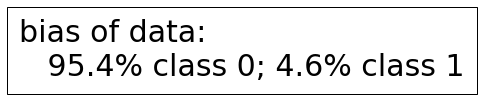

In [10]:
# Test the bias of the data
#bias=(Y==1).mean()
bias=Y.mean()
text=[]
text.append("bias of data:")
text.append("   {0:.1%} class 0; {1:.1%} class 1".format(1-bias,bias))
textbox(text)

Huge bias : only 4.6% of Townhouses!

In [11]:
X.describe()

count    82.000000
mean      2.464476
std       1.948505
min       0.600000
25%       1.252500
50%       1.712000
75%       3.183750
max      11.003000
Name: SQUARE FEET/1000, dtype: float64

In [12]:
# Imputing missing values

# Works much better with more than 1 column LOL
# Benjamin : sometimes the simplest answer (yours) is the best, I'm sorry '^^
#from sklearn.impute import SimpleImputer
#imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
#Explain Benjamin : need to reshape ( see with >1 feature in documentation)
#fit_transform : common method used with this kind of object
#values = imp_mean.fit_transform(X.array.reshape(-1, 1))# .array.reshape(-1, 1) .reshape(X.array.shape)
#X = pd.DataFrame(values, index= X.index,  columns=[X.name])

In [13]:
X = X.fillna(X.mean())

In [14]:
# Z-scoring the data
X_scored=scipy.stats.zscore(X).array

## Training a model

In [15]:
# Fitting the Logistic Regression
Fit1 = sklearn.linear_model.LogisticRegression(solver="lbfgs",random_state=0, penalty = 'none').fit(X_scored.reshape(-1,1),Y.values)
(m_sk,b_sk)=(Fit1.coef_.item(),Fit1.intercept_.item())
print("sklearn coefficients for normalizd data: m={0:.3f}, b={1:.2f}".format(m_sk,b_sk))

sklearn coefficients for normalizd data: m=-1.167, b=-3.38


In [16]:
data["pred_townhouse"] = Fit1.predict(X.array.reshape(-1,1))

C:\Users\Benjamin\AppData\Local\Temp\ipykernel_20224\1545535344.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["pred_townhouse"] = Fit1.predict(X.array.reshape(-1,1))


In [17]:
data.pred_townhouse

record number
1      0
2      0
3      0
4      0
5      0
      ..
104    0
105    0
106    0
107    0
108    0
Name: pred_townhouse, Length: 108, dtype: int32

In [18]:
data[["proba_notownhouse", "proba_townhouse"]]= Fit1.predict_proba(X.array.reshape(108,1))

C:\Users\Benjamin\AppData\Local\Temp\ipykernel_20224\2082748240.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[["proba_notownhouse", "proba_townhouse"]]= Fit1.predict_proba(X.array.reshape(108,1))
C:\Users\Benjamin\AppData\Local\Temp\ipykernel_20224\2082748240.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[["proba_notownhouse", "proba_townhouse"]]= Fit1.predict_proba(X.array.reshape(108,1))


In [19]:
data

,SQUARE FEET/1000,townhouse,pred_townhouse,proba_notownhouse,proba_townhouse
record number,,,,,
1,1.520,0,0,0.994229,0.005771
2,0.900,0,0,0.988177,0.011823
3,3.135,0,0,0.999119,0.000881
4,3.219,1,0,0.999201,0.000799
5,1.600,0,0,0.994741,0.005259
...,...,...,...,...,...
104,NaN,0,0,0.998075,0.001925
105,1.600,0,0,0.994741,0.005259
106,5.865,0,0,0.999964,0.000036


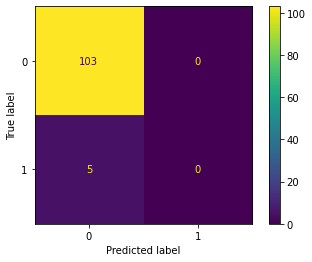

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = sklearn.metrics.confusion_matrix(y_true= data.townhouse , y_pred = data.pred_townhouse, labels=[0, 1], sample_weight=None, normalize=None)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

In [21]:
sklearn.metrics.classification_report(y_true= data.townhouse , y_pred = data.pred_townhouse, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=True, zero_division=0)

{'0': {'precision': 0.9537037037037037,
  'recall': 1.0,
  'f1-score': 0.976303317535545,
  'support': 103},
 '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5},
 'accuracy': 0.9537037037037037,
 'macro avg': {'precision': 0.47685185185185186,
  'recall': 0.5,
  'f1-score': 0.4881516587677725,
  'support': 108},
 'weighted avg': {'precision': 0.9095507544581619,
  'recall': 0.9537037037037037,
  'f1-score': 0.9311040898718623,
  'support': 108}}

In [22]:
# Loss from the fitted model
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
loss_entropy = log_loss(y_true= data.townhouse, y_pred= data.proba_townhouse, eps='auto', normalize=True, sample_weight=None, labels=None)

average_errors = 1- accuracy_score(y_true = data.townhouse.astype(int), y_pred = data.pred_townhouse.astype(int), normalize=True, sample_weight=None)

print("Loss : {0:.3f},  Average number of classification errors : {1:.3f}".format(loss_entropy,average_errors))
print("The average number of classification errors is exactly the proportion of Townhouses in the dataset, since all the Townhouses are predicted as Non-Townhouses.")

TypeError: unsupported operand type(s) for -: 'int' and 'str'

# Conclusion

We can see that according to the result of logistic regression, the model can successfully predict Not-Townhouse, but Townhouse cannot be captured. It can be explained by the fact that there are only 5 points of Townhouses in the dataset.

In fact, looking at the confusion matrix, the model predicts only Not-Townhouses. Plus, delving into the classification report, average metrics show a fairly good performance (90% accuracy), but the macro average metrics (50% accuracy) highlight the fact that the Townhouses are neglected and the apparent good performance is driven by the disproportionate amount of Non-Townhouses.

In addition, the loss of the model does not seem to be that large either, so it comes to the conclusion that the data points of Townhouse are simply not enough for the model to detect the difference between Not-Townhouse and Townhouse, or maybe it would be better if we apply other methods, such as resampling, random forest, or class_weight, to predict the data. (The appendix shows that changing the weights decreases indeed the loss, but the final predictions are exactly the same.)

Finally, by comparing the loss of the Single family residential home from the lecture, we find out the loss of predicting townhouse is still lower than the SFR log-model. It shows that the disproportionate data points significantly biases the performance of the predictor, while the SFR model from the lecture had more balanced data.

In conclusion, like we discussed in the lecture, New York city has a very large portion of apartments for sale, where we can barely find SFR homes and town houses. So we should carefully choose the wanted label to avoid bias or increase the sample size to find a better prediction.

## Appendix : Balanced regression

In [ ]:
# Fitting the Logistic Regression (Model Fit2)
Fit2 = sklearn.linear_model.LogisticRegression(solver="lbfgs",random_state=0, penalty = None, class_weight= "balanced").fit(X_scored.reshape(-1,1),Y.values)
(m_sk_2,b_sk_2)=(Fit2.coef_.item(),Fit2.intercept_.item())
print("sklearn coefficients for normalized data, and correcting the bias: m={0:.3f}, b={1:.2f}".format(m_sk_2,b_sk_2))

In [ ]:
# Predict result by having Fit 2 model
data["pred_townhouse_2"] = Fit2.predict(X.array.reshape(-1,1))
data[["proba_notownhouse_2", "proba_townhouse_2"]]= Fit2.predict_proba(X.array.reshape(108,1))

In [ ]:
data.describe()

In [ ]:
# Graphing the Truth Table in different quandrants
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = sklearn.metrics.confusion_matrix(y_true= data.townhouse , y_pred = data.pred_townhouse_2, labels=[0, 1], sample_weight=None, normalize=None)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

In [ ]:
# Loss from the fit model 2
from sklearn.metrics import log_loss
log_loss(y_true= data.townhouse, y_pred= data.proba_townhouse_2, eps='auto', normalize=True, sample_weight=None, labels=None)

The entropy loss is lower because the probabilities of Townhouses are enhanced thanks to the weights, but the final predictions remain the same.